# Colossus tutorial: halo density profiles

Welcome to the Colossus halo density profile tutorial.

In [1]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

As always with Colossus, we need to set a cosmology.

In [2]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');

## Profile basics

The density profile module in Colossus is object-oriented: it contains a base class for all density profiles, and classes for specific models that are derived from the base class. Those derived classes need to implement only one function (density), but can overwrite other functions, for example if there are analytical solutions for quantities that would otherwise need to be computed numerically. At first, we don't need to concern ourselves with this architecture though.

To get started, let's create different density profile predictions for a massive cluster halo at $z = 0$. Profiles can often be initialized by different sets of parameters. For example, an NFW profile can take it's native parameters (central density and scale radius), but can also be initialized using the mass and concentration:

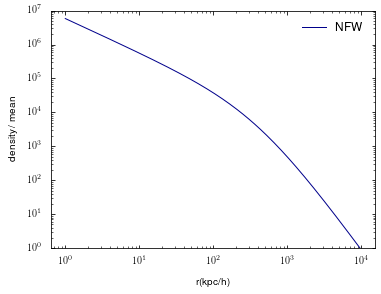

In [3]:
from colossus.halo import profile_nfw

Mvir = 1E15
cvir = 5.0
z = 0.0
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

r = 10**np.arange(0,4,0.02)
rho_m = cosmo.rho_m(z)
rho_nfw = p_nfw.density(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW');
plt.ylim(1E0, 1E7)
plt.legend();

Note that the Colossus halo module works in physical coordinates. Let's compute the predictions of other profile models for the same halo:

In [4]:
from colossus.halo import profile_einasto
from colossus.halo import profile_dk14

p_einasto = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_dk14 = profile_dk14.DK14Profile(M = Mvir, c = cvir, z = z, mdef = 'vir')

rho_einasto = p_einasto.density(r)
rho_dk14 = p_dk14.density(r)

Let's add the scale radius and virial radius for the NFW profile for clarity. Spherical overdensity radii and masses can be obtained with the `RDelta` and `MDelta` functions. The scale radius is part of the internal parameters of the NFW model, and is thus an entry in the par dictionary that each profile holds:

In [5]:
Rvir_nfw = p_nfw.RDelta(z, 'vir')
print(p_nfw.par)
rs = p_nfw.par['rs']

OrderedDict([('rhos', 1234754.506870338), ('rs', 406.6464224896049)])


The contents of this dictionary will vary between profile models. For example, for the Einasto profile, it also contains the $\alpha$ parameter which determines how fast the profile steepens:

In [6]:
print(p_einasto.par)

OrderedDict([('rhos', 319480.0218020434), ('rs', 406.6464224896049), ('alpha', 0.24889220802384998)])


Anyway, let's put all of that into a plot:

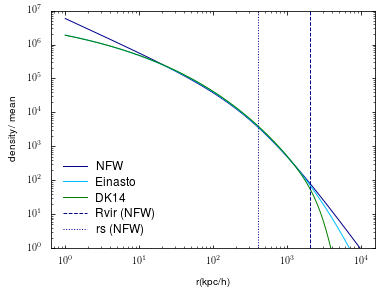

In [7]:
plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW');
plt.plot(r, rho_einasto / rho_m, '-', label = 'Einasto');
plt.plot(r, rho_dk14 / rho_m, '-', label = 'DK14');
plt.axvline(Rvir_nfw, ls = '--', label = 'Rvir (NFW)');
plt.axvline(rs, ls = ':', label = 'rs (NFW)');
plt.ylim(1E0, 1E7)
plt.legend();

Of course, we can plot numerous quantities other than density, for example surface density. Please see the [documentation of the HaloDensityProfile](https://bdiemer.bitbucket.io/colossus/halo_profile_base.html) base class for an exhaustive list.

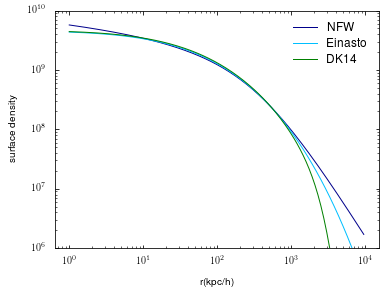

In [8]:
Sigma_nfw = p_nfw.surfaceDensity(r)
Sigma_einasto = p_einasto.surfaceDensity(r)
Sigma_dk14 = p_dk14.surfaceDensity(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('surface density')
plt.plot(r, Sigma_nfw, '-', label = 'NFW');
plt.plot(r, Sigma_einasto, '-', label = 'Einasto');
plt.plot(r, Sigma_dk14, '-', label = 'DK14');
plt.ylim(1E6, 1E10)
plt.legend();

## The outer profile

The differences between profiles in the plot above are mostly apparent at small and large radii. But at large radii, the profile becomes complicated due to non-linear infall and the contribution from other halos (the 2-halo term). In Colossus, such components can be added to the profiles:

In [9]:
from colossus.halo import profile_outer

outer_term_mean = profile_outer.OuterTermMeanDensity(z = z)
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir', outer_terms = [outer_term_mean])

For the DK14 profile, power-law outer profiles are standard and can be generated with a wrapper function:

In [10]:
p_dk14 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir, c = cvir, z = z, mdef = 'vir', outer_term_names = ['pl'])

Now let's plot a comparison of the profiles with outer terms:

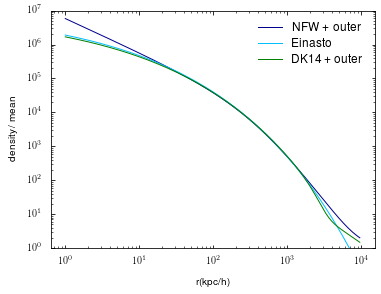

In [11]:
rho_nfw = p_nfw.density(r)
rho_einasto = p_einasto.density(r)
rho_dk14 = p_dk14.density(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW + outer');
plt.plot(r, rho_einasto / rho_m, '-', label = 'Einasto');
plt.plot(r, rho_dk14 / rho_m, '-', label = 'DK14 + outer');
plt.ylim(1E0, 1E7)
plt.legend();

Let's add an outer term based on the correlation function to the NFW profile. We compute the bias from the [Tinker et al. 2010](http://adsabs.harvard.edu/abs/2010ApJ...724..878T) bias model:

In [12]:
from colossus.lss import bias
b = bias.haloBias(Mvir, z, 'vir')
print(b)
outer_term_xi = profile_outer.OuterTermCorrelationFunction(z = z, bias = b)
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir', outer_terms = [outer_term_xi])

6.000318965492275


The differences in the outer profiles are more apparent if we plot the slope instead:

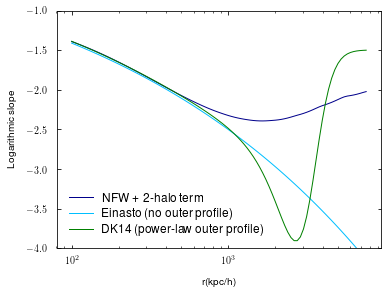

In [13]:
r = 10**np.arange(2,3.9,0.02)
slope_nfw = p_nfw.densityDerivativeLog(r)
slope_einasto = p_einasto.densityDerivativeLog(r)
slope_dk14 = p_dk14.densityDerivativeLog(r)

plt.figure()
plt.xscale('log')
plt.xlabel('r(kpc/h)')
plt.ylabel('Logarithmic slope')
plt.plot(r, slope_nfw, '-', label = 'NFW + 2-halo term');
plt.plot(r, slope_einasto, '-', label = 'Einasto (no outer profile)');
plt.plot(r, slope_dk14, '-', label = 'DK14 (power-law outer profile)');
plt.ylim(-4, -1)
plt.legend();

## Profile fitting

Let's generate an NFW profile of surface density and some scattered fake data round it:

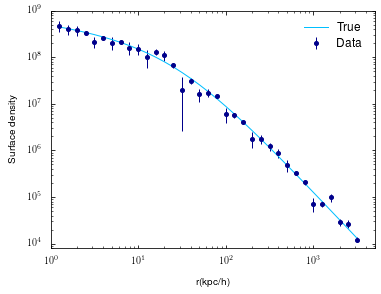

In [14]:
# Generate NFW profile
Mvir = 1E12
cvir = 7.0
p = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = 0.0, mdef = 'vir')

# Generate random scatter around the true surface density profile
r = 10**np.arange(0.1, 3.6, 0.1)
sigma_true = p.surfaceDensity(r)
np.random.seed(155)
sigma_err = np.abs(np.random.normal(0.2, 0.1, (len(r)))) * sigma_true
sigma = sigma_true.copy()
for i in range(len(r)):
    sigma[i] += np.random.normal(0.0, sigma_err[i])

plt.figure()
plt.loglog()
plt.xlim(1E0, 5E3)
plt.ylim(8E3, 1E9)
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, sigma_true, '-', color = 'deepskyblue', label = 'True')
plt.legend()
plt.errorbar(r, sigma, yerr = sigma_err, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'Data')
plt.legend();

Now let's generate a bad initial guess of the NFW profile, and recover it by fitting. First, let's see what the true parameters of the NFW profile are. The mask tells the fitter to fit all parameters, whereas False elements are held fixed.

In [15]:
mask = np.array([True, True])
x_true = p.getParameterArray(mask)
print(x_true)

[2.69611026e+06 2.90461730e+01]


We generate a bad initial guess and set the profile parameters to that guess:

In [16]:
ini_guess = x_true * 1.5
p.setParameterArray(ini_guess, mask = mask)
sigma_ini = p.surfaceDensity(r)

Now fit the profile to the data. The `fit()` function has many more parameters than discussed here. For example, it can handle covariance matrices, use an MCMC instead of least-squares, and fit density, surface density, enclosed mass and so on. The function's outputs are gathered in one dictionary.

In [17]:
dict = p.fit(r, sigma, 'Sigma', q_err = sigma_err, mask = mask)
sigma_fit = dict['q_fit']

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 19 steps. Best-fit parameters:
Parameter       rhos = 2.58e+06 [2.41e+06 .. 2.77e+06]
Parameter         rs = 2.95e+01 [2.86e+01 .. 3.04e+01]
chi2 / Ndof = 35.7 / 33 = 1.08
-------------------------------------------------------------------------------------


The fitter output tells us that we've recovered the input parameters quite exactly. We also get error estimates and a lot of other output. Let's put it all together in a plot:

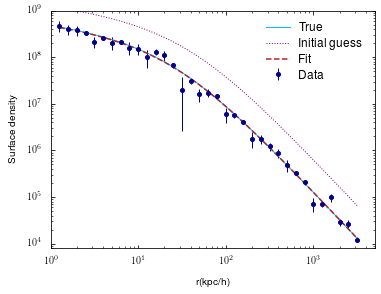

In [18]:
plt.figure()
plt.loglog()
plt.xlim(1E0, 5E3)
plt.ylim(8E3, 1E9)
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, sigma_true, '-', color = 'deepskyblue', label = 'True')
plt.plot(r, sigma_ini, ':', color = 'purple', label = 'Initial guess')
plt.plot(r, sigma_fit, '--', color = 'firebrick', lw = 1.5, label = 'Fit')
plt.legend()
plt.errorbar(r, sigma, yerr = sigma_err, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'Data')
plt.legend();

Besides the standard least-squares fit, colossus also has an MCMC fitter (contributed by Andrey Kravtsov). The code below once again creates a fiducial NFW profile with some noise, but this time fits it using both least-squares and MCMC. Due to the large number of evaluations, MCMC fits can get very slow, especially if computationally expensive quantities such as the surface density profile are fit.

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Found analytical derivative function for quantity rho.
Found solution in 7 steps. Best-fit parameters:
Parameter       rhos = 9.54e+05 [7.31e+05 .. 1.25e+06]
Parameter         rs = 4.95e+01 [4.32e+01 .. 5.68e+01]
chi2 / Ndof = 9.1 / 8 = 1.14
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Running MCMC with the following settings:
Number of parameters:                      2
Number of walkers:                       100
Save conv. indicators every:             500
Finish when Gelman-Rubin less than:   0.0100
-------------------------------------------------------------------------------------
Step    500, autocorr. time  38.9, GR = [  1.086  1.099]
Step   1000, autocorr. time  36.8, GR = [  1.036  1.043]


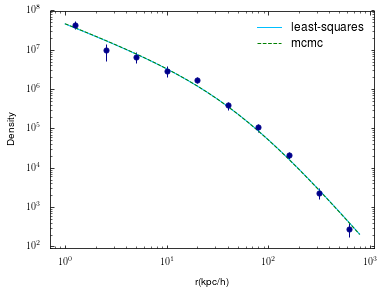

In [19]:
# Create a "true" NFW profile
cosmology.setCosmology('WMAP9')
rhos = 1E6
rs = 50.0
prof = profile_nfw.NFWProfile(rhos = rhos, rs = rs)

# Create a fake dataset with some noise
r = 10**np.arange(0.1, 3.0, 0.3)
rr = 10**np.arange(0.0, 3.0, 0.1)
rho_data = prof.density(r)
sigma = 0.25 * rho_data
np.random.seed(156)
rho_data += np.random.normal(0.0, sigma, len(r))

# Move the profile parameters away from the initial values
prof.setParameterArray([prof.par['rhos'] * 0.4, prof.par['rs'] * 3.0])

# Fit to the fake data using least-squares, compute the fitted profile
prof.fit(r, rho_data, 'rho', q_err = sigma, method = 'leastsq')
rho_fit_leastsq = prof.density(rr)

# Fit to the fake data using MCMC, compute the fitted profile
fit_results = prof.fit(r, rho_data, 'rho', q_err = sigma, method = 'mcmc', convergence_step = 500)
rho_fit_mcmc = prof.density(rr)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('Density')
plt.errorbar(r, rho_data, yerr = sigma, fmt = 'o', ms = 5.0)
plt.plot(rr, rho_fit_leastsq, '-', label = 'least-squares')
plt.plot(rr, rho_fit_mcmc, '--', label = 'mcmc')
plt.legend()
plt.show()

The `fit()` function has returned the full output from the MCMC, so we can additionally plot the MCMC samples (see the MCMC tutorial).

## General spline profiles

In addition to the analytical profile forms that we have explored so far, Colossus also offers a generalized profile that can be initialized from a table of density or enclodes mass. Let's test how well this interpolated profile does compared to a "true" NFW profile:

Initializing spline profile from 6 radial bins.


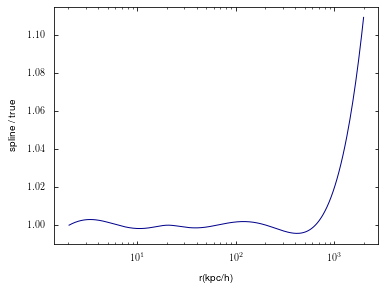

In [20]:
from colossus.halo import mass_so
from colossus.halo import profile_spline

cosmology.setCosmology('planck15')

#Create an NFW profile
mdef = 'vir'
p_nfw = profile_nfw.NFWProfile(M = 1E12, c = 10.0, mdef = mdef, z = 0.0)

# Create a coarse array of radii and evaluate the NFW density
Rvir = mass_so.M_to_R(Mvir, z, mdef)
r = 10**np.arange(-2.0, 1.0, 0.5) * Rvir
rho = p_nfw.density(r)

# Create a spline profile from the radius array
print('Initializing spline profile from %d radial bins.' % (len(r)))
p_spline = profile_spline.SplineProfile(r, rho = rho)

# Now create a much finer array of radii and test how well the spline does
r = 10**np.arange(-2.0, 1.0, 0.01) * Rvir
rho_m = cosmo.rho_m(z)
rho_nfw = p_nfw.density(r)
rho_spline = p_spline.density(r)

plt.figure()
plt.xscale('log')
plt.xlabel('r(kpc/h)')
plt.ylabel('spline / true')
plt.plot(r, rho_spline / rho_nfw, '-');

The spline does surprisingly well, given that we only used 6 bins! But at large radii, we see why we need to be careful with spline profiles: at the boundary, interpolation errors creep in. Thus, we must always make sure to cover a radial range larger than where the profile will be used.

## Creating a new density profile model

While the most commonly used density profile models are implemented in colossus, you may well want to overwrite the HaloDensityProfile base class yourself. For example, let's implement the [Hernquist 1990](http://adsabs.harvard.edu/abs/1990ApJ...356..359H) model (this profile is already implemented in Colossus, but it's a good example anyway):

In [21]:
from colossus.halo import profile_base

class HernquistProfile(profile_base.HaloDensityProfile):

    def __init__(self, rhos, rs):

        self.par_names = ['rhos', 'rs']
        self.opt_names = []
        profile_base.HaloDensityProfile.__init__(self)

        self.par['rhos'] = rhos
        self.par['rs'] = rs

        return

    def densityInner(self, r):

        x = r / self.par['rs']
        density = self.par['rhos'] / x / (1.0 + x)**3

        return density

In the constructor, we had to make the profile class conscious of its internal parameters (central density and scale radius, just as for the NFW profile). This self-awareness is necessary for the fitting routines. Other than that, the only function we had to overwrite was `densityInner()`. Note that our new constructor does not yet have the ability to convert mass and concentration to central density and scale radius. Thus, we use an NFW profile to obtain a reasonable central density and scale radius:

In [22]:
Mvir = 1E12
cvir = 7.0
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
rhos = p_nfw.par['rhos']
rs = p_nfw.par['rs']
p_hernquist = HernquistProfile(rhos = rhos, rs = rs)

Now we can use our new profile object in all the same ways demonstrated above, including all the functionality of the base class. For example, we can evaluate the surface density profile even though we never told our new class how to compute that:

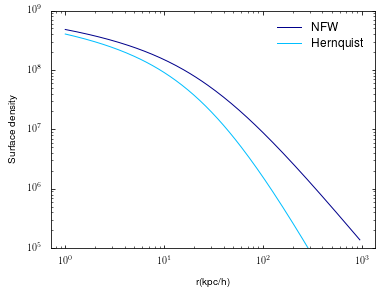

In [23]:
r = 10**np.arange(0,3,0.02)
Sigma_nfw = p_nfw.surfaceDensity(r)
Sigma_hernquist = p_hernquist.surfaceDensity(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, Sigma_nfw, '-', label = 'NFW');
plt.plot(r, Sigma_hernquist, '-', label = 'Hernquist');
plt.ylim(1E5, 1E9)
plt.legend();

Note, however, that certain functions might be less accurate or relatively slow. For example, the slope of the density profile would be computed numerically - in the case of the Hernquist profile, it would make sense to overwrite that function using the analytical expression for the slope.